# Projet TP AARN : Détection de Spam.

USTHB, Faculté d'Informatique, Département IA & SD.

SII, Master 1.

**Trinôme G1** :
- 191931066239 - **AMAZOUZ Sara Selma**
- 191931045284 - **GHENAIET Walid**
- 191931089336 - **MOULAI Mohamed Youcef**


---



Dans ce projet, on veut fournir un modèle qui classifie aussi bien les spams que les non-spams. Pour cela, on va devoir importer les mails étiquetés d'un dossier et les nettoyer des mots et caractères inutiles, pour ensuite les encoder afin que les algorithmes puissent les utiliser pour faire des prédictions.

# **0. Importation des librairies**

In [ ]:
import re
import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk

In [ ]:
from google.colab import drive as drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **1. Importation de la Data**

**- Fonction d'importation:** permet de parcourir les fichiers d'un dossier à partir de son chemin dans le Drive

In [ ]:
def get_data(path):
    encoding = "ISO-8859-1"
    # liste qui contiendra tous les mails
    data = []
    files = os.listdir(path)
    print(files)
    path=path+"/"

    for filename in files:
        file = open(f"{path}{filename}", encoding=encoding)
        # lecture du contenu du fichier
        words_list = file.read()
        data.append(words_list)
        file.close()
    return data

In [ ]:
easy_ham_path = "/content/gdrive/My Drive/archive/easy_ham/easy_ham"
hard_ham_path = "/content/gdrive/My Drive/archive/hard_ham/hard_ham"
spam_path = "/content/gdrive/My Drive/archive/spam_2/spam_2"

easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
spam = get_data(spam_path)

ham = easy_ham + hard_ham
spam = spam

mails = ham + spam

X = np.array(mails, dtype=object)
y = np.array([0] * len(ham) + [1] * len(spam))

['1464.1bf98a5939c5dccf46f3e7c482e7e906', '1591.6b6ae63033581aaf40cb6a6d08da2662', '2075.711e8f761dd164a7bcafc3ab23c96735', '2414.9762e257ad9e6b6633dba8432ffb90de', '2139.9ba6145b574aaa5184fbe919d9a64fb4', '1786.59383d91430d9cb58e7d0aa4e25b1320', '2249.8cb268b72e28cb7a5ff8d500e6f332cf', '1691.dc18b18697ac2c2d7e5024eb8be84ecb', '1736.9ae2cf6f768fe1d218ddb61cea78e523', '1935.323e3a0e8b8ecafaf86e9fa18db016fd', '1459.74fc3984acd4e3e9f00e77f599d2fe27', '1967.39e72b1ec8530a135486f51b91c5e9c9', '1958.2e664403f1d45b88d08abed4ae1b5c80', '1837.e1c6a4364e0762f323cd69d23e030fc8', '1462.ef8fdbd441dade85c95fa014b058b896', '2157.f89b3083fea3eaceabba7a30ca82369a', '1784.0e74974631f665395f5e6b01148b4bee', '1488.6694aa49b517656806a631deeb8f89a8', '2186.9dc59321a95e53d5e0ebaf3524858913', '1813.c86ae674674567c5779cfb7a30385e45', '2055.bf3873bdfb04c1fc4b4e88f4794f8260', '2340.40c9d3c3940d1c4a9ec570ce144798d2', '1869 (1).7e629f0611df5503ab8608b3cfd9def6', '2044.44bf59ea8589daeadc7af5f5c4d7827a', '2384.835c5

**Data visualisation**

In [ ]:
def plot_target(ham, spam):

  plt.figure(figsize=(4, 3))
  sns.countplot(x = ['ham']*len(ham) + ['spam']*len(spam))
  plt.show()

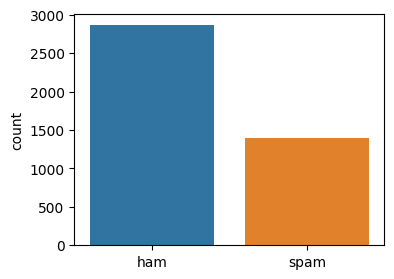

In [ ]:
plot_target(ham, spam)

On remarque qu'on a plus d'emails dits "ham" que les spams (le double)

# **2. Pré-traitement de la Data**

Suppression de mots inutiles

In [ ]:
def uselessWords (texte):

    return re.sub(r"^\s*(To:|From:|Subject:|Date:|Content\W(.*?):)", "", texte)

Minuscule

In [ ]:
def minuscule(texte):

  return(texte.lower())

Suppression des balises HTML

In [ ]:
def supp_html(texte):

  return re.sub('<[^<>]+>', ' ', texte)

Normalisation des URLs

In [ ]:
def norm_urls(texte):

    return re.sub(r'(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*', 'httpaddr', texte)

Normalisation des adresses e-mails

In [ ]:
def norm_emails(texte):

    return re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', "emailaddr", texte)

Normalisation des nombres

In [ ]:
def norm_numbers(texte):

    return re.sub(r'\d+', 'nombre', texte)

Normalisation des dollars

In [ ]:
def norm_dollars(texte):

    return re.sub(r"\$", 'dollar', texte)

Radicalisation et Tokenization des mots

In [ ]:
def stemTok(texte):

  # liste qui contiendra les mots radicalisés
  stemmed_texte =[]

  # diviser les phrases en mots (Tokenization)
  texte = texte.split()

  # parcourir chaque mot du texte
  for mot in texte:

      # suppression de tout caractère alphanumérique
      mot = re.sub('[^a-zA-Z0-9]', '', mot)

      # radicalisateur pour les mots en Anglais
      stemmer = nltk.stem.snowball.SnowballStemmer("english")

      # radicalisation du mot
      mot = stemmer.stem(mot.strip())

      # elimination des mots de longueur inférieure à 2 (inutiles)
      if len(mot) < 2:
        continue

      stemmed_texte.append(mot)

  return stemmed_texte

Suppression des non-mots

In [ ]:
def supp_nonMots(texte):

    # ponctuation
    texte = re.sub(r"[!\"$%&'()*+,-./:;<=>?@[\]^_`{|}~]", "  ", texte)

    # \t & \n
    texte = re.sub(r"[\t\n]", "  ", texte)

    # espace
    texte = re.sub(r"\s{2,}", " ", texte)

    # les espaces inutiles
    texte = texte.strip()

    return texte

Déroulement de la radicalisation des mots sur un exemple

In [ ]:
texte = "discount, discounts, discounted et discounting devront être tous remplacé par  discount, et include includes, included, et included devront être tous remplacés par « includ »."
print(texte)
tkn = stemTok(texte)
print(tkn)

discount, discounts, discounted et discounting devront être tous remplacé par  discount, et include includes, included, et included devront être tous remplacés par « includ ».
['discount', 'discount', 'discount', 'et', 'discount', 'devront', 'tre', 'tous', 'remplac', 'par', 'discount', 'et', 'includ', 'includ', 'includ', 'et', 'includ', 'devront', 'tre', 'tous', 'remplac', 'par', 'includ']


**- Fonction de nettoyage d'un mail:** elle regroupe toutes les fonctions qui pré-traitent les mails.

In [ ]:
def nettoyage(data):

    # Application de toutes les fonctions
    data = uselessWords(data)
    data = minuscule(data)
    data = supp_html(data)
    data = norm_urls(data)
    data = norm_emails(data)
    data = norm_numbers(data)
    data = norm_dollars(data)
    data = supp_nonMots(data)
    data = stemTok(data)

    return data

Déroulement des fonctions implémentées sur un exemple

In [ ]:
texte = """> Anyone knows how much it costs to host a web portal ?
>

Well, it depends on how many visitors youre expecting. This can be
anywhere from less than 10 bucks a month to a couple of $100. You
should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if
youre running something big..

To unsubscribe yourself from this mailing list, send an email to:

groupname-unsubscribe@egroups.com"""
print(texte)
print("after preprocessing :")
print(nettoyage(texte))

> Anyone knows how much it costs to host a web portal ?
>

Well, it depends on how many visitors youre expecting. This can be
anywhere from less than 10 bucks a month to a couple of $100. You
should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if
youre running something big..

To unsubscribe yourself from this mailing list, send an email to:

groupname-unsubscribe@egroups.com
after preprocessing :
['anyon', 'know', 'how', 'much', 'it', 'cost', 'to', 'host', 'web', 'portal', 'well', 'it', 'depend', 'on', 'how', 'mani', 'visitor', 'your', 'expect', 'this', 'can', 'be', 'anywher', 'from', 'less', 'than', 'nombr', 'buck', 'month', 'to', 'coupl', 'of', 'dollarnombr', 'you', 'should', 'checkout', 'httpaddr', 'or', 'perhap', 'amazon', 'ecnombr', 'if', 'your', 'run', 'someth', 'big', 'to', 'unsubscrib', 'yourself', 'from', 'this', 'mail', 'list', 'send', 'an', 'email', 'to', 'emailaddr']


Importation des mots inutiles dans la langue Anglaise

In [ ]:
nltk.download('stopwords', quiet=True)

True

**- Fonction de pré-traitement:** parcourt et nettoie tous les mails du dataset.

In [ ]:
def preprocessing(mail):
  print("preprocessing...")
  preprocessed_mail = [nettoyage(email) for email in mail]
  print("finished successfully!")
  return preprocessed_mail

In [ ]:
prep_mails = preprocessing(mails)

preprocessing...
finished successfully!


Exemple du contenu d'un mail après le pré-traitement.

In [ ]:
print(prep_mails[0])

['from', 'emailaddr', 'thu', 'aug', 'nombr', 'nombr', 'nombr', 'nombr', 'nombr', 'return', 'path', 'deliv', 'to', 'emailaddr', 'receiv', 'from', 'localhost', 'localhost', 'nombr', 'nombr', 'nombr', 'nombr', 'by', 'phobo', 'lab', 'netnoteinc', 'com', 'postfix', 'with', 'esmtp', 'id', 'enombr', 'for', 'thu', 'nombr', 'aug', 'nombr', 'nombr', 'nombr', 'nombr', 'nombr', 'edt', 'receiv', 'from', 'phobo', 'nombr', 'nombr', 'nombr', 'nombr', 'by', 'localhost', 'with', 'imap', 'fetchmail', 'nombr', 'nombr', 'nombr', 'for', 'jm', 'localhost', 'singl', 'drop', 'thu', 'nombr', 'aug', 'nombr', 'nombr', 'nombr', 'nombr', 'nombr', 'ist', 'receiv', 'from', 'usw', 'sf', 'listnombr', 'sourceforg', 'net', 'usw', 'sf', 'fwnombr', 'sourceforg', 'net', 'nombr', 'nombr', 'nombr', 'nombr', 'by', 'dogma', 'slashnul', 'org', 'nombr', 'nombr', 'nombr', 'nombr', 'nombr', 'nombr', 'with', 'esmtp', 'id', 'gnombresntpznombr', 'for', 'thu', 'nombr', 'aug', 'nombr', 'nombr', 'nombr', 'nombr', 'nombr', 'receiv', 'from

**- Fonction de collecte de tokens:** collecte les mots de chaque email dans tout le dataset en eliminant les mots inutiles.

(raw vocabulary)

In [ ]:
def get_tokens(data):

    print("getting tokens...")
    # liste qui contiendra tous les mots extraits des mails
    tokens = []
    # parcourir chaque mail dans le dataset
    for email in data:
        # ajout de tous les éléments de la liste email, à la liste tokens
        tokens += email

    # suppression des mots inessentiels
    stopwords = nltk.corpus.stopwords.words('english')
    tokens = [x for x in tokens if x not in stopwords and len(x)!= 2]
    print("finished successfully!")
    return tokens

In [ ]:
tokens = get_tokens(prep_mails)
print(len(tokens), " tokens")

getting tokens...
finished successfully!
1809557  tokens


**- Fonction de sélection des tokens importants:** sélectionne, depuis le vocabulaire, les mots qui se répètent le plus selon un nombre *k* empirique.

In [ ]:
def get_vocab(tokens, k):
    # counter génère un dictionnaire avec le nombre d'occurences de chaque clé (chaque mot dans notre cas)
    counter = Counter(tokens)
    # mettre tous les k premiers mots dans la nouvelle liste
    k_tokens = [word for word, _ in counter.most_common(k)]
    return k_tokens

In [ ]:
vocab = get_vocab(tokens, 3000)
print(tokens)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



**- Fonction de sauvegarde du vocabulaire:** permet de préserver le vocabulaire obtenu sous la forme d'un fichier *txt* pour d'éventuelles études.

In [ ]:
def save_vocab(vocab):

  path = "./vocab.txt"
  # ouvrir le fichier en mode écriture
  with open(path, "w", encoding="utf-8") as file:
    file.write(vocab)
  print("vocabulary saved.")

**- Fonction de map:** assigne a chaque mot du vocabulaire un nombre unique.

In [ ]:
def mapping(vocab):

  # dictionnaire qui contiendra les clé-valeur
  token_to_index = dict()
  i = 0
  # parcourir les mots du vocabulaire
  for i in range(len(vocab)):
    # assigner i au mot vocab[i]
    token_to_index[vocab[i]] = i

  return token_to_index

Exemple

In [ ]:
tokens_mapped = mapping(vocab)
print(tokens_mapped)

{'nombr': 0, 'emailaddr': 1, 'receiv': 2, 'com': 3, 'list': 4, 'nbsp': 5, 'localhost': 6, 'httpaddr': 7, 'esmtp': 8, 'net': 9, 'sep': 10, 'mail': 11, 'version': 12, 'org': 13, 'content': 14, 'messag': 15, 'date': 16, 'aug': 17, 'spam': 18, 'mon': 19, 'postfix': 20, 'oct': 21, 'thu': 22, 'wed': 23, 'subject': 24, 'text': 25, 'tue': 26, 'ist': 27, 'jul': 28, 'type': 29, 'email': 30, 'deliv': 31, 'return': 32, 'dogma': 33, 'slashnul': 34, 'use': 35, 'nombre': 36, 'path': 37, 'dollarnombr': 38, 'jalapeno': 39, 'get': 40, 'fri': 41, 'anombr': 42, 'mime': 43, 'time': 44, 'repli': 45, 'free': 46, 'singl': 47, 'may': 48, 'drop': 49, 'xent': 50, 'smtp': 51, 'one': 52, 'html': 53, 'encod': 54, 'fetchmail': 55, 'bnombr': 56, 'charset': 57, 'plain': 58, 'help': 59, 'imap': 60, 'requir': 61, 'new': 62, 'test': 63, 'user': 64, 'dnombr': 65, 'quot': 66, 'sender': 67, 'unsubscrib': 68, 'hit': 69, 'level': 70, 'transfer': 71, 'status': 72, 'nombrec': 73, 'netnoteinc': 74, 'cnombr': 75, 'click': 76, 'li

**- Fonction de transfomation & remplissage (par comptage):** transforme les mots des emails du dataset a des nombres selon le map effectué ci-dessus et remplis X avec le nombre d'occurences de ces derniers.

In [ ]:
def counterVec(mapped, vocab, email):

    # pour chaque mot dans un mail, rechercher si le mot est dans le vocabulaire (k mots les plus importants) alors on le remplace par sa valeur selon le mapping
    transformed = [mapped[token] for token in email if token in vocab]
    X = np.zeros((1, len(vocab)))

    # parcourir X et incrémenter
    for i in transformed:
        X[0][i] += 1

    return X

In [ ]:
counterVect = counterVec(tokens_mapped, vocab, prep_mails[0])
print(counterVect)
print(counterVect.shape)

[[509.   7.   7. ...   0.   0.   0.]]
(1, 3000)


In [ ]:
def createX(mapped, vocab, emails):

  print("creating and padding X...")
  # X l'ensemble de données contient : nbr d'emails = lignes, nbr de tokens = colonnes
  X = np.zeros((len(emails), len(vocab))).astype(float)
  print(X.shape)
  # parcourir chaque mail et appliquer la transformation et le remplissage
  for i in range(len(emails)):
    cvec = counterVec(mapped, vocab, emails[i])
    X[i][:] = cvec.copy()
  print("creation finished successfully!")
  return X

In [ ]:
X = createX(tokens_mapped, vocab, prep_mails)
print(X)

creating and padding X...
(4267, 3000)
creation finished successfully!
[[509.   7.   7. ...   0.   0.   0.]
 [121.  11.   8. ...   0.   0.   0.]
 [ 59.   3.   3. ...   0.   0.   0.]
 ...
 [171.  16.  11. ...   0.   0.   0.]
 [ 91.  11.   6. ...   0.   0.   0.]
 [102.  13.   4. ...   0.   0.   0.]]


In [ ]:
print(X.shape)

(4267, 3000)


**Construction de la partie d'entrainement et de la partie du test:**
- ***TrainTestSplit:*** permet de diviser le X et y en deux parties: entrainement et test.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, cross_validate
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

CV=StratifiedKFold(4)

# **3. Construction des modèles & Résultats**

- ***Pipeline:*** permet de regrouper plusieurs fonctions qui traite, transforme les données.

Justif: Optimisation du code.

- ***Standard Scaler:*** Ramène les valeurs à une moyenne égale à 0.

Justif: Certains modèles ont besoin d'un standardiseur pour ne pas qu'ils deviennent trop lent pour converger vers les meilleurs paramètres.

- ***Cross Validation:*** Une confirmation supplémentaire de l'évaluation. On sépare l'ensemble en *K* parties (selon les lignes), on entraine le modèle *K* fois en considerant à chaque fois une partie des *K* parties comme partie de test et les autres comme partie d'entrainement.

Justif: Avoir un modèle plus consistant et éviter l'Overfitting.

- ***Stratified K Fold:*** Une technique de la cross validation, permet une distribution équitable des données des deux classes.

Justif: C'est la meilleure méthode pour le cas d'un dataset déséquilibré.

- ***Grid Search:*** permet d'avoir la meilleure configuration possible à partir d'un ensemble fixé de valeurs des hyperparamètres.


**- Fonction d'affichage des métriques:** affiche la matrice de confusion, ainsi que les différents métriques pour chaque algorithme.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score, precision_score, recall_score, f1_score

def metrics(y_test, y_pred, name):

  print("\n", name, "\n")
  print("Accuracy:", accuracy_score(y_test, y_pred))
  print("Precision:", precision_score(y_test, y_pred))
  print("Recall:", recall_score(y_test, y_pred))
  print("F1-score: ", f1_score(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

**- Fonction d'affichage de la courbe ROC**

In [ ]:
def ROCurve(y_pred_proba):

  fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

  sns.set()

  plt.plot(fpr, tpr)

  plt.plot(fpr, fpr, linestyle = '--', color = 'k')

  plt.xlabel('False positive rate')

  plt.ylabel('True positive rate')

  AUROC = np.round(roc_auc_score(y_test, y_pred_proba), 2)

  plt.title(f'Model ROC curve; AUROC: {AUROC}');

  plt.show()

*Logistic Regression*

In [ ]:
from sklearn.linear_model import LogisticRegression

def LogReg(x_train, x_test, y_train, y_test, name):

  print(name, "\n")
  # entrainement
  print("test1")
  LR = LogisticRegression(random_state=42).fit(x_train, y_train.ravel())
  print("test1")
  # test
  metrics(y_test.ravel(), LR.predict(x_test), "default logistic regression")
  ROCurve(LR.predict_proba(np.array(x_test))[:,1])

  # hyper-parametres
  hyper_params_LR = {'logisticregression__C': [0.001,0.01,0.1,0.2,0.3,0.5,0.8,1],
                     'logisticregression__penalty':['l1', 'l2']
                     }
  # entrainement
  grid_LR = GridSearchCV(make_pipeline(StandardScaler(), LR), hyper_params_LR, cv=CV).fit(x_train, y_train)
  # test
  metrics(y_test, grid_LR.predict(x_test), "improved logistic regression")
  ROCurve(grid_LR.predict_proba(np.array(x_test))[:,1])

LOGISTIC REGRESSION 

test1


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


test1

 default logistic regression 

Accuracy: 0.994535519125683
Precision: 0.989769820971867
Recall: 0.9923076923076923
F1-score:  0.9910371318822023
[[887   4]
 [  3 387]]


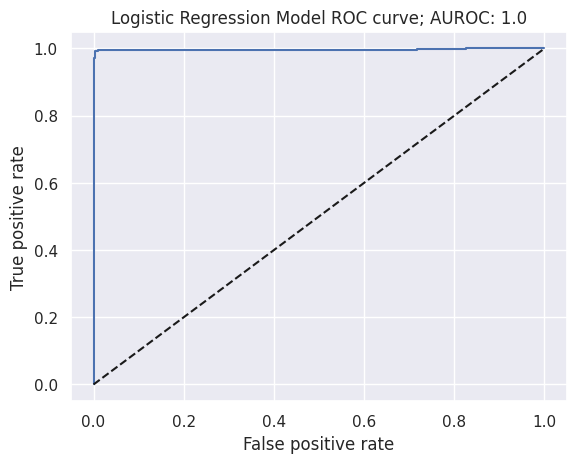

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
32 fits failed out of a total of 64.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
32 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py", line 405, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
 


 improved logistic regression 

Accuracy: 0.9937548790007806
Precision: 0.9872448979591837
Recall: 0.9923076923076923
F1-score:  0.9897698209718669
[[886   5]
 [  3 387]]


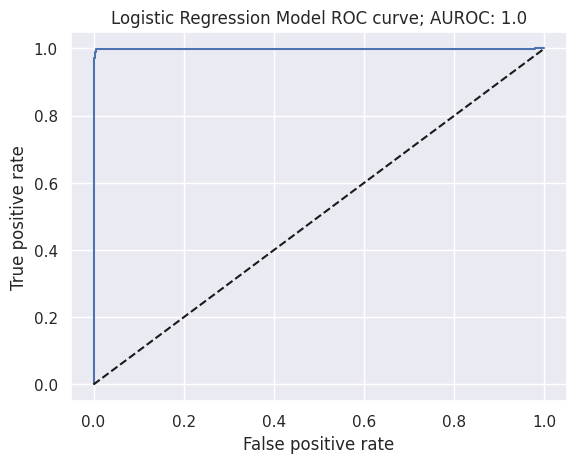

In [ ]:
LogReg(x_train, x_test, y_train, y_test, "LOGISTIC REGRESSION")

*Decision Tree*

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def DTree(x_train, x_test, y_train, y_test, name):

  print(name, "\n")
  # entrainement
  DT = DecisionTreeClassifier(random_state=42).fit(x_train, y_train)
  # test
  metrics(y_test, DT.predict(x_test), "default decision tree")
  ROCurve(DT.predict_proba(np.array(x_test))[:,1])

  # hyper-parametres
  hyper_params_DT = {'decisiontreeclassifier__max_depth': [50, 100, 250, 500, 1000, 1500, 2000],
                    'decisiontreeclassifier__criterion' : ['gini', 'entropy']
                     }
  # entrainement
  grid_DT = GridSearchCV(make_pipeline(StandardScaler(), DT), hyper_params_DT, cv=CV).fit(x_train, y_train)
  # test
  metrics(y_test, grid_DT.predict(x_test), "improved decision tree")
  ROCurve(grid_DT.predict_proba(np.array(x_test))[:,1])


DECISION TREE 


 default decision tree 

Accuracy: 0.9859484777517564
Precision: 0.979381443298969
Recall: 0.9743589743589743
F1-score:  0.9768637532133676
[[883   8]
 [ 10 380]]


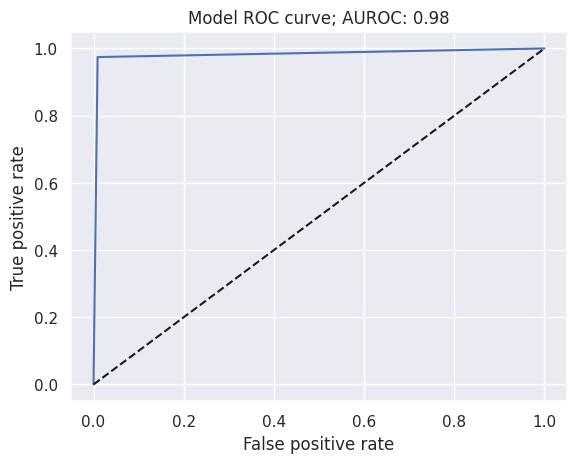


 improved decision tree 

Accuracy: 0.990632318501171
Precision: 0.9796954314720813
Recall: 0.9897435897435898
F1-score:  0.9846938775510204
[[883   8]
 [  4 386]]


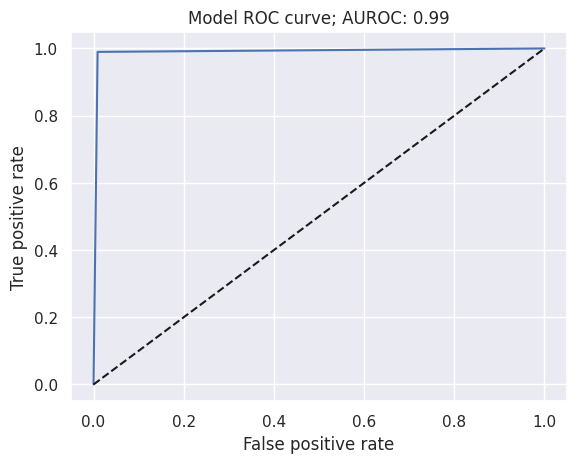

In [ ]:
DTree(x_train, x_test, y_train, y_test, "DECISION TREE")

*Random Forest*

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def RForest(x_train, x_test, y_train, y_test, name):

  print(name, "\n")
  # entrainement
  RF = RandomForestClassifier(random_state=42).fit(x_train, y_train)
  # test
  metrics(y_test, RF.predict(x_test), "default random forest")
  ROCurve(RF.predict_proba(np.array(x_test))[:,1])

  # hyper-parametres
  hyper_params_RF = {'randomforestclassifier__max_depth': [50, 100, 250, 500, 1000, 1500, 2000]
                     }
  # entrainement
  grid_RF = GridSearchCV(make_pipeline(StandardScaler(), RF), hyper_params_RF, cv=CV).fit(x_train, y_train)
  # test
  metrics(y_test, grid_RF.predict(x_test), "improved random forest")
  ROCurve(grid_RF.predict_proba(np.array(x_test))[:,1])


RANDOM FOREST 


 default random forest 

Accuracy: 0.9937548790007806
Precision: 0.9847715736040609
Recall: 0.9948717948717949
F1-score:  0.9897959183673469
[[885   6]
 [  2 388]]


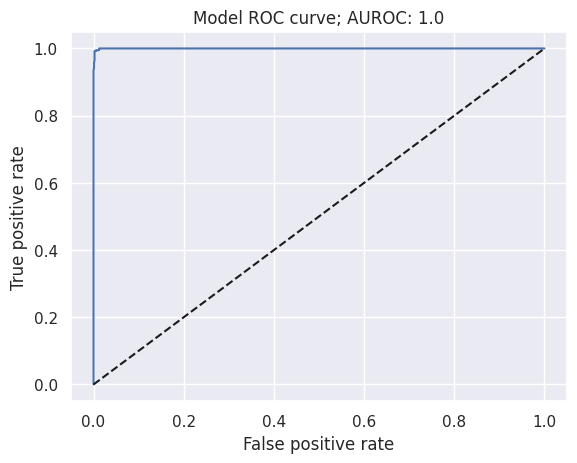


 improved random forest 

Accuracy: 0.994535519125683
Precision: 0.9872773536895675
Recall: 0.9948717948717949
F1-score:  0.9910600255427842
[[886   5]
 [  2 388]]


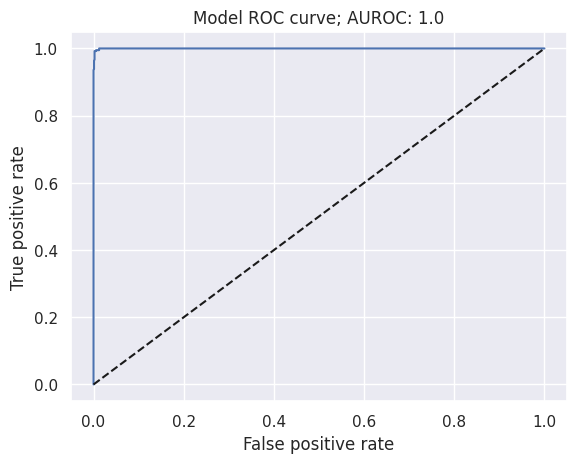

In [ ]:
RForest(x_train, x_test, y_train, y_test, "RANDOM FOREST")

*Neural Network*

In [ ]:
from sklearn.neural_network import MLPClassifier

def NNetwork(x_train, x_test, y_train, y_test, name):

  print(name, "\n")
  # entrainement
  NN = MLPClassifier(random_state=42).fit(x_train, y_train)
  # test
  metrics(y_test, NN.predict(x_test), "default neural network")
  ROCurve(NN.predict_proba(np.array(x_test))[:,1])


  # hyper-parametres
  hyper_params_NN = {'mlpclassifier__learning_rate': ['constant','adaptive'],
                     'mlpclassifier__activation': ['logistic','relu'],
                     }
  # entrainement
  grid_NN = GridSearchCV(make_pipeline(StandardScaler(), NN), hyper_params_NN, cv=CV).fit(x_train, y_train)
  # test
  metrics(y_test, grid_NN.predict(x_test), "improved neural network")
  ROCurve(grid_NN.predict_proba(np.array(x_test))[:,1])


NEURAL NETWORK 


 default neural network 

Accuracy: 0.9953161592505855
Precision: 0.9873096446700508
Recall: 0.9974358974358974
F1-score:  0.9923469387755102
[[886   5]
 [  1 389]]


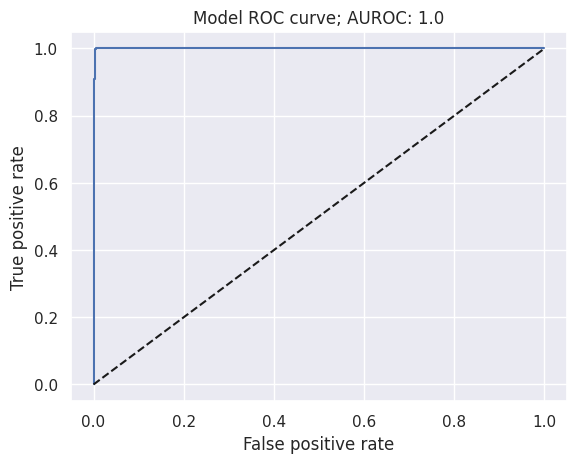


 improved neural network 

Accuracy: 0.990632318501171
Precision: 0.9725
Recall: 0.9974358974358974
F1-score:  0.9848101265822785
[[880  11]
 [  1 389]]


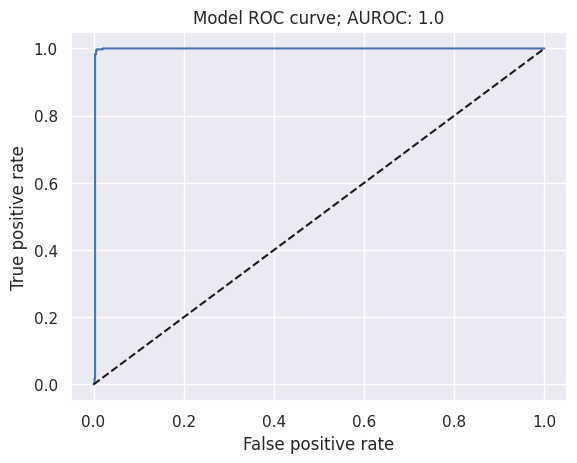

In [ ]:
NNetwork(x_train, x_test, y_train, y_test, "NEURAL NETWORK")

*SVM*

In [ ]:
from sklearn.svm import SVC

def SupportVM(x_train, x_test, y_train, y_test, name):

  print(name, "\n")
  # entrainement
  SVM = SVC(random_state=42,probability=True).fit(x_train, y_train)
  # test
  metrics(y_test, SVM.predict(x_test), "default svm")
  ROCurve(SVM.predict_proba(np.array(x_test))[:,1])


  # hyper-parametres
  hyper_params_SVC = {'svc__C': [0.001,0.1,1]
                     }
  # entrainement
  grid_SVC = GridSearchCV(make_pipeline(StandardScaler(), SVM), hyper_params_SVC, cv=CV).fit(x_train, y_train)
  # test
  metrics(y_test, grid_SVC.predict(x_test), "improved svm")
  ROCurve(grid_SVC.predict_proba(np.array(x_test))[:,1])


SUPPORT VECTOR MACHINE 


 default svm 

Accuracy: 0.9836065573770492
Precision: 0.9718670076726342
Recall: 0.9743589743589743
F1-score:  0.9731113956466069
[[880  11]
 [ 10 380]]


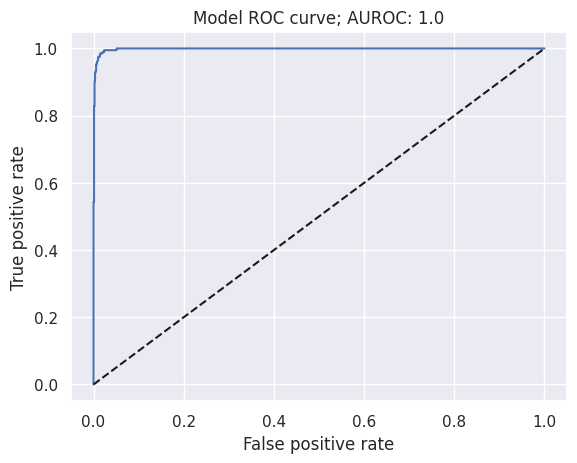


 improved svm 

Accuracy: 0.9812646370023419
Precision: 0.9972826086956522
Recall: 0.941025641025641
F1-score:  0.9683377308707125
[[890   1]
 [ 23 367]]


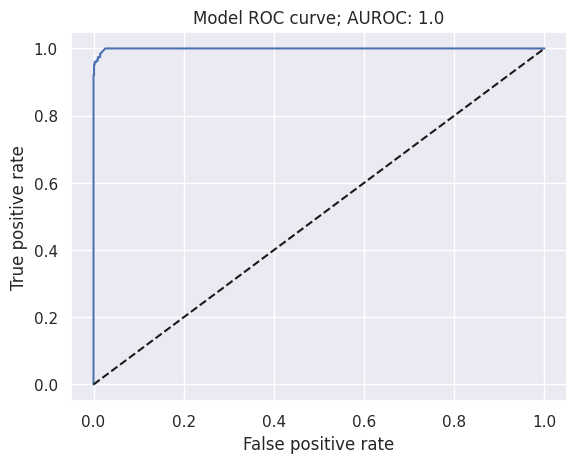

In [ ]:
SupportVM(x_train, x_test, y_train, y_test, "SUPPORT VECTOR MACHINE")

*KNN*

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


def KNNeighbors(x_train, x_test, y_train, y_test, name):

  print(name, "\n")
  # entrainement
  KNN = KNeighborsClassifier().fit(x_train, y_train)
  # test
  metrics(y_test, KNN.predict(x_test), "default knn")
  ROCurve(KNN.predict_proba(np.array(x_test))[:,1])

  # hyper-parametres
  hyper_params_KNN = {
              'kneighborsclassifier__n_neighbors': range(3, 30, 3),
              'kneighborsclassifier__metric': ['euclidean', 'manhattan']
                     }
  # entrainement
  grid_KNN = GridSearchCV(make_pipeline(StandardScaler(), KNN), hyper_params_KNN, cv=CV).fit(x_train, y_train)
  # test
  metrics(y_test, grid_KNN.predict(x_test), "improved knn")
  ROCurve(grid_KNN.predict_proba(np.array(x_test))[:,1])

K Nearest Neighbors 


 default knn 

Accuracy: 0.9664324746291959
Precision: 0.9392405063291139
Recall: 0.9512820512820512
F1-score:  0.9452229299363057
[[867  24]
 [ 19 371]]


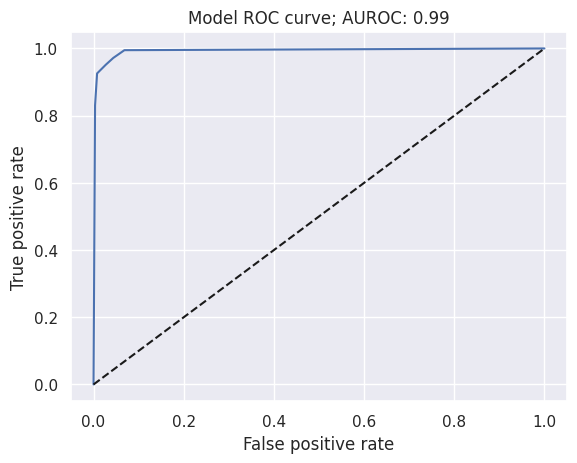


 improved knn 

Accuracy: 0.9586260733801717
Precision: 0.914004914004914
Recall: 0.9538461538461539
F1-score:  0.9335006273525723
[[856  35]
 [ 18 372]]


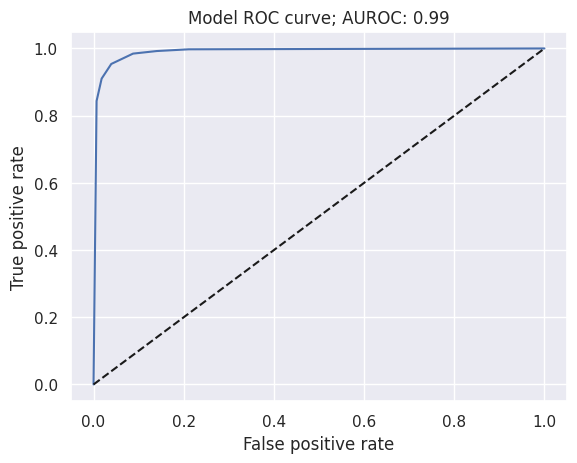

In [ ]:
KNNeighbors(x_train, x_test, y_train, y_test, "K Nearest Neighbors")

**Résultats**

- KNN est le plus "mauvais" d'entre eux.

- SVM et les réseaux de neurones prennent trop de temps a s'exécuter.

- SVM arrive a très bien classifier les ham (la classe majoritaire)

- Les réseaux de neurones classifient très bien les spams (la classe minoritaire), mais aussi les spams.

- Tous les scores et la courbe ROC de tous les modèles se rapprochent beaucoup de 1 ; Soit la classification est facile, cela veut dire que les attributs (vocabulaire) choisis sont très déterminants. Ou bien il y a un problème d'Overfitting. (on peut essayer de régler le problème de Data Imbalance avec les techniques de suréchantillonage comme SMOTE)

- Dans notre cas, le Recall est plus important que la Précision car détecter tous les spams qu'on reçoit par mail est plus prudent. Ce n'est pas *très grave* de mal classifier un ham. Du coup, on prendra le modèle qui a le meilleur Recall score.

- Le modèle qui utilise les réseaux de neurones est le mieux adapté à notre solution du problème.

- grid_NN sera choisit car il est plus consistant (Cross Validation)